# CMPT 898: Assigment 2 Solutions
## By Samuel Horovatin, sch923, 11185403

### Question 1: *Re-implement the Keras tutorial for image classification in TensorFlow without using tf.keras objects.*

In [1]:
import tensorflow as tf
import numpy as np
import os, datetime

epochs = 50

(x_train, y_train),(x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalization of x_train and x_test
x_train, x_test = x_train / 255.0, x_test / 255.0


4423680/4422102 [==============================] - 0s 0us/step


In [2]:
#REMOVE BEFORE SUBMISSION

print(y_train[1])
print('Before Reshape:', )
print("After Reshape:",np.reshape(x_train[1], (-1, 28, 28, 1)).shape)

0
Before Reshape:
After Reshape: (1, 28, 28, 1)


In [3]:
# Takes a tensor and by default flattens it to 28 by 28
def flatten(tensor,shape=(28,28)):
  return tf.reshape(tensor, shape)

# A relu density function. Takes a tensor x, scalar wieght W, and tensor bias b.
def dense_relu(x, W, b):
  return tf.nn.relu(tf.matmul(x, W) + b)

# A dropout function that by default converts 20% of the input tensor x to 0.
def dropout(tensor,rate=0.2):
  return tf.nn.dropout(tensor, rate)

# A softmax density function. Takes a tensor x, scalar wieght W, and a tensor b.
def dense_softmax(x, W, b):
  return tf.nn.softmax(tf.matmul(x, W) + b)


# TODO
#def cross_enthropy(actual_p, predicted_p):

# TODO
# def optimizer_adam(alpha=0.001):


def gen_weight():
  return tf.Variable(
    tf.random.normal(
    shape=[1,x_train.shape[2]],
    seed=43))

@tf.function
def multilayer_network(x, W1, W2):
  x = flatten(x)
  x = dense_relu(x, W1, b)
  x = dropout(x)
  x = dense_softmax(x, W2, b)
  return x



### Question 2: Create two random square matrix and preform matrix multiplication. Create a table to report the compute time for CPU vs GPU for matrix size 500, 1000, 5000, 10000.

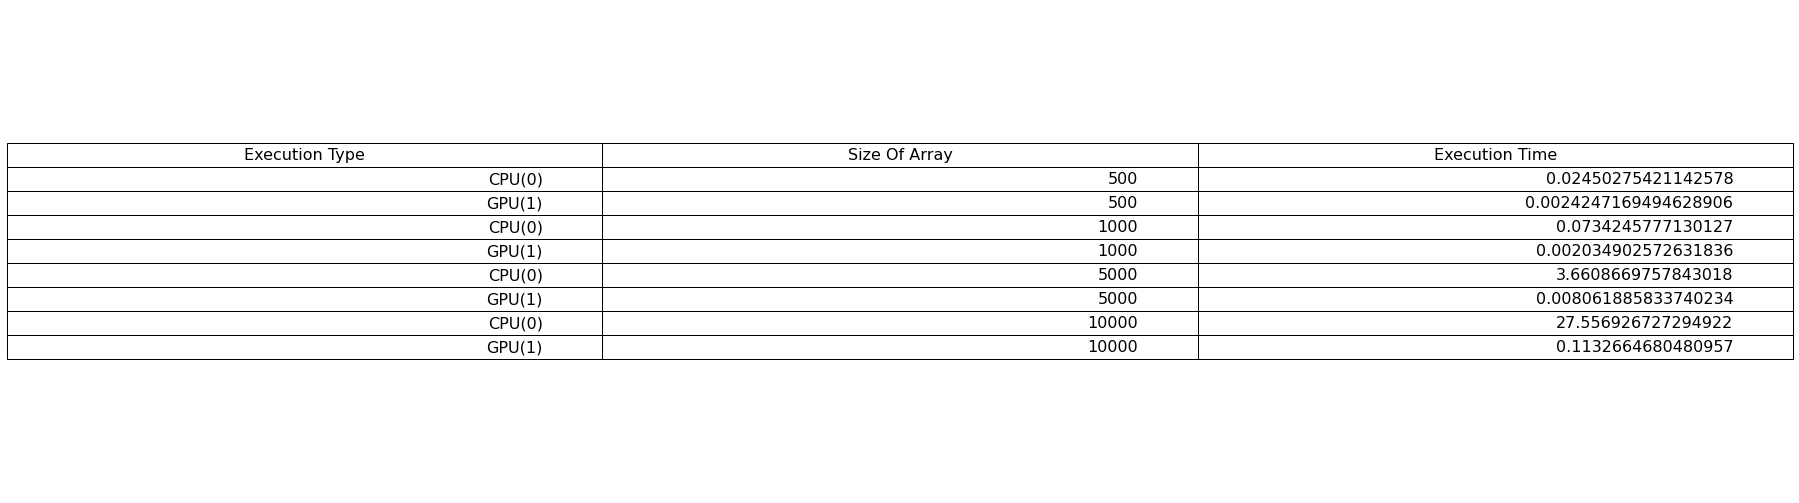

In [33]:
import tensorflow as tf
import time
import pandas as pd
import matplotlib.pyplot as plt

# Generates a random square matrix of size x 
def gen_square_matrix(x):
  return tf.Variable( tf.random.normal(shape=[x,x],seed=43) )

# Generates two random square matrix of size x 
# and reports the time in seconds it takes to matrix multiply them.
def time_matrix_multiplication(x):
    start_time = time.time()
    tf.matmul(gen_square_matrix(x), gen_square_matrix(x))
    elapse_time = time.time()-start_time
    return elapse_time

# Preform CPU Multiplication
with tf.device('/cpu:0'):
  CPU_time_500 = time_matrix_multiplication(500)
  CPU_time_1000 = time_matrix_multiplication(1000)
  CPU_time_5000 = time_matrix_multiplication(5000)
  CPU_time_10000 = time_matrix_multiplication(10000)

# Preform GPU Multiplication
with tf.device('/device:GPU:0'):
  GPU_time_500 = time_matrix_multiplication(500)
  GPU_time_1000 = time_matrix_multiplication(1000)
  GPU_time_5000 = time_matrix_multiplication(5000)
  GPU_time_10000 = time_matrix_multiplication(10000)

# Create table
fig, axes = plt.subplots()

# Hides unneeded axes
fig.patch.set_visible(False)
axes.axis('off')
axes.axis('tight')

# Data assembly
tablelabel = ("Execution Type", "Size Of Array", "Execution Time")
tabledata = ([("CPU(0)", 500, CPU_time_500),
              ("GPU(1)", 500, GPU_time_500),
              ("CPU(0)", 1000, CPU_time_1000), 
              ("GPU(1)", 1000, GPU_time_1000),
              ("CPU(0)", 5000, CPU_time_5000), 
              ("GPU(1)", 5000, GPU_time_5000),
              ("CPU(0)", 10000, CPU_time_10000),
              ("GPU(1)", 10000, GPU_time_10000)])
table_df = pd.DataFrame(tabledata, columns=tablelabel)
 
# Plot table with some formatting
table = axes.table(cellText=table_df.values, colLabels=table_df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(2,2)
plt.show()

### Question 3: Given the polynomial $y = x^2 + 2x +3$, implement the expression in tensor flow, and print out the result of performing differentiation of the expression. Compare this to the result of evaluating a manually derived expression by hand. Use the test case $x = \begin{pmatrix} 2\\ 4\end{pmatrix}$.